In [5]:
import pandas as pd
import talib as ta
import numpy as np


def preprocess_data(
    z_: pd.DataFrame,
    ret_periods: int = 24,
    vol_window: int = 24,
    atr_period: int = 14,
) -> pd.DataFrame:
    """数据预处理：计算收益率、波动率、ATR（小时级可调）"""
    z = z_.copy()
    z["ret"] = z["close"].pct_change().fillna(0)

    # 小时级：默认用近1天(24小时)的动量与波动率衡量信号强度
    z["rolling_ret"] = z["close"].pct_change(periods=ret_periods).fillna(0)
    z["rolling_vol"] = z["ret"].rolling(window=vol_window).std().fillna(1e-6)
    z["signal_strength"] = z["rolling_ret"] / z["rolling_vol"]

    z["atr"] = ta.ATR(z["high"], z["low"], z["close"], timeperiod=atr_period)
    z["position"] = 0.0
    z["flag"] = 0.0
    return z


def preprocess_data_v2(
    z_: pd.DataFrame,
    ret_periods: int = 24,
    vol_window: int = 24,
    atr_period: int = 14,
    sma_fast: int = 48,
    sma_slow: int = 200,
    adx_period: int = 14,
    breakout_lookback: int = 48,
) -> pd.DataFrame:
    """V2 预处理：仅做多所需的趋势/波动/突破特征。
    要求输入为 1 小时 K 线 DataFrame，至少包含: ['open','high','low','close']，索引为时间。
    """
    z = z_.copy()
    # 基础收益与波动
    z["ret"] = z["close"].pct_change().fillna(0)
    z["rolling_ret"] = z["close"].pct_change(periods=ret_periods).fillna(0)
    z["rolling_vol"] = z["ret"].rolling(window=vol_window).std().fillna(1e-6)
    z["signal_strength"] = z["rolling_ret"] / z["rolling_vol"]
    # 信号 zscore（长期均值/方差）
    _mean = z["signal_strength"].rolling(240).mean()
    _std = z["signal_strength"].rolling(240).std().replace(0, 1)
    z["signal_z"] = ((z["signal_strength"] - _mean) / _std).fillna(0)

    # 趋势与动量过滤
    z["sma_fast"] = z["close"].rolling(sma_fast).mean()
    z["sma_slow"] = z["close"].rolling(sma_slow).mean()
    z["adx"] = ta.ADX(z["high"], z["low"], z["close"], timeperiod=adx_period)

    # ATR 与突破价
    z["atr"] = ta.ATR(z["high"], z["low"], z["close"], timeperiod=atr_period)
    z["hh"] = (
        z["high"].rolling(breakout_lookback).max().shift(1)
    )  # 上一根之前 N 小时最高

    # 初始化列（与 V1 并存，使用带 _v2 后缀）
    z["position_v2"] = 0.0
    z["flag_v2"] = 0.0
    return z


def run_strategy_v2(
    z: pd.DataFrame,
    z_long: float = 0.8,  # 入场信号强度阈值（z-score）
    k_init: float = 2.0,  # 初始 ATR 止损倍数
    k_trail: float = 2.5,  # 追踪 ATR 止损倍数
    time_stop_hours: int = 24 * 10,  # 时间止损（持仓最久小时数）
    cool_down_hours: int = 24,  # 冷却期：平仓后 N 小时内不再开新仓
    use_adx: bool = True,
    adx_min: float = 15.0,
) -> tuple:
    """V2 仅做多、全仓、无费率版本。
    入场：趋势过滤(仅多头)，signal_z > z_long，且收盘上破过去 N 小时高点。
    出场：初始 ATR 止损 + 追踪 ATR 止损 + 时间止损 + 趋势失效（SMA48 下穿 SMA200）。
    结果列：position_v2、flag_v2、nav_v2、benchmark。
    返回: (DataFrame, 交易记录DataFrame)
    """
    Buy, Sell = [], []

    # 需要的最小起始索引
    sma_fast = int(
        z.get("sma_fast").rolling(1).window
        if hasattr(z.get("sma_fast"), "rolling")
        else 48
    )  # 兜底
    sma_slow = 200
    atr_period = 14
    breakout_lookback = 48
    i_start = max(240, sma_slow, breakout_lookback, atr_period)

    in_pos = False
    entry_price = 0.0
    entry_i = -(10**9)
    init_stop = None
    trail_stop = None
    highest_high = 0.0
    last_exit_i = -(10**9)

    for i in range(i_start, len(z)):
        idx = z.index[i]
        close = z["close"].iloc[i]
        high = z["high"].iloc[i]
        atr = z["atr"].iloc[i]

        # 趋势过滤（仅多头）
        regime_up = (close > z["sma_slow"].iloc[i]) and (
            z["sma_fast"].iloc[i] > z["sma_slow"].iloc[i]
        )
        if use_adx:
            regime_up = regime_up and (z["adx"].iloc[i] >= adx_min)

        # 默认沿用上一根仓位
        prev_pos = z["position_v2"].iloc[i - 1]
        z.at[idx, "position_v2"] = prev_pos

        # 尝试开仓
        if (not in_pos) and (i - last_exit_i >= cool_down_hours):
            cond_signal = z["signal_z"].iloc[i] > z_long
            cond_breakout = close > z["hh"].iloc[i]
            if regime_up and cond_signal and cond_breakout:
                in_pos = True
                z.at[idx, "flag_v2"] = 1
                z.at[idx, "position_v2"] = 1
                entry_price = close
                entry_i = i
                highest_high = high
                init_stop = entry_price - k_init * atr
                trail_stop = highest_high - k_trail * atr
                Buy.append(
                    [
                        idx,
                        entry_price,
                        f'开仓: z={z["signal_z"].iloc[i]:.2f}, ATR={atr:.2f}',
                    ]
                )
                print(
                    idx,
                    f'【V2开仓】z={z["signal_z"].iloc[i]:.2f}, 价格={entry_price:.2f}, 初始止损={init_stop:.2f}',
                )
                continue

        # 管理持仓
        if in_pos:
            highest_high = max(highest_high, high)
            # 动态追踪止损
            trail_stop = max(trail_stop, highest_high - k_trail * atr)
            # 趋势失效
            trend_invalid = not (
                (z["sma_fast"].iloc[i] > z["sma_slow"].iloc[i])
                and (close > z["sma_slow"].iloc[i])
            )
            # 触发任何离场条件
            stop_price = max(init_stop, trail_stop)
            hit_stop = close <= stop_price
            time_stop = (i - entry_i) >= time_stop_hours

            if hit_stop or time_stop or trend_invalid:
                in_pos = False
                z.at[idx, "flag_v2"] = -1
                z.at[idx, "position_v2"] = 0
                price_out = close
                reason = (
                    "止损" if hit_stop else ("时间止损" if time_stop else "趋势失效")
                )
                Sell.append([idx, price_out, f"{reason}: stop={stop_price:.2f}"])
                last_exit_i = i
                print(idx, f"【V2平仓】{reason}，价格={price_out:.2f}")
                # 清空变量以防误用
                init_stop = None
                trail_stop = None
                highest_high = 0.0
                entry_price = 0.0

    # 交易记录
    p1 = pd.DataFrame(Buy, columns=["买入日期", "买入价格", "备注"])
    p2 = pd.DataFrame(Sell, columns=["卖出日期", "卖出价格", "备注"])
    transaction = pd.concat([p1, p2], axis=1)

    # 净值（V2）
    z["ret"] = z["close"].pct_change().fillna(0)
    effective_position = z["position_v2"].shift(1).fillna(0)
    z["nav_v2"] = (1 + z["ret"] * effective_position).cumprod()
    z["nav"] = z["nav_v2"]  # 兼容性：让 nav 指向 nav_v2
    z["benchmark"] = z["close"] / z["close"].iloc[0]

    return z, transaction


成功读取文件: D:/workspace/data/crypto/1min/BTCUSDT/BTCUSDT-1m-2022-01.zip
列名: ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume', 'count', 'taker_buy_volume', 'taker_buy_quote_volume', 'ignore']
数据形状: (44640, 12)
成功读取文件: D:/workspace/data/crypto/1min/BTCUSDT/BTCUSDT-1m-2022-02.zip
列名: ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume', 'count', 'taker_buy_volume', 'taker_buy_quote_volume', 'ignore']
数据形状: (40320, 12)
成功读取文件: D:/workspace/data/crypto/1min/BTCUSDT/BTCUSDT-1m-2022-03.zip
列名: ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume', 'count', 'taker_buy_volume', 'taker_buy_quote_volume', 'ignore']
数据形状: (44640, 12)
成功读取文件: D:/workspace/data/crypto/1min/BTCUSDT/BTCUSDT-1m-2022-04.zip
列名: ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume', 'count', 'taker_buy_volume', 'taker_buy_quote_volume', 'ignore']
数据形状: (43200, 12)
成功读取文件: D:/workspace/data/crypto

C:\Users\youdo\AppData\Local\Temp\ipykernel_50120\1305493833.py:42: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  z["ret"] = z["close"].pct_change().fillna(0)
C:\Users\youdo\AppData\Local\Temp\ipykernel_50120\1305493833.py:43: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  z["rolling_ret"] = z["close"].pct_change(periods=ret_periods).fillna(0)


2022-01-29 13:00:00 【V2开仓】z=1.56, 价格=38161.69, 初始止损=37503.18
2022-01-30 09:00:00 【V2平仓】止损，价格=37889.48
2022-02-04 23:00:00 【V2开仓】z=2.09, 价格=41574.25, 初始止损=40515.72
2022-02-06 14:00:00 【V2平仓】止损，价格=41306.34
2022-02-07 14:00:00 【V2开仓】z=1.29, 价格=43411.15, 初始止损=42674.65
2022-02-08 08:00:00 【V2平仓】止损，价格=44004.51
2022-02-28 16:00:00 【V2开仓】z=0.91, 价格=41010.09, 初始止损=39716.56
2022-03-01 16:00:00 【V2平仓】止损，价格=43385.53
2022-03-18 17:00:00 【V2开仓】z=0.94, 价格=41661.86, 初始止损=40998.25
2022-03-19 07:00:00 【V2平仓】止损，价格=41610.00
2022-03-22 03:00:00 【V2开仓】z=1.69, 价格=42236.46, 初始止损=41532.60
2022-03-22 06:00:00 【V2平仓】止损，价格=42247.99
2022-03-24 14:00:00 【V2开仓】z=1.19, 价格=43582.11, 初始止损=42862.40
2022-03-25 16:00:00 【V2平仓】止损，价格=44150.00
2022-03-27 20:00:00 【V2开仓】z=0.93, 价格=46115.80, 初始止损=45485.50
2022-03-28 23:00:00 【V2平仓】止损，价格=47122.21
2022-04-20 10:00:00 【V2开仓】z=1.41, 价格=41821.38, 初始止损=41340.08
2022-04-20 14:00:00 【V2平仓】止损，价格=41549.13
2022-05-30 20:00:00 【V2开仓】z=2.33, 价格=31277.18, 初始止损=30723.69
2022-05-31 09:00:00 【

C:\Users\youdo\AppData\Local\Temp\ipykernel_50120\1305493833.py:186: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  z["ret"] = z["close"].pct_change().fillna(0)
d:\Project\miniConda\env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20928 (\N{CJK UNIFIED IDEOGRAPH-51C0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Project\miniConda\env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Project\miniConda\env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31574 (\N{CJK UNIFIED IDEOGRAPH-7B56}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Project\min

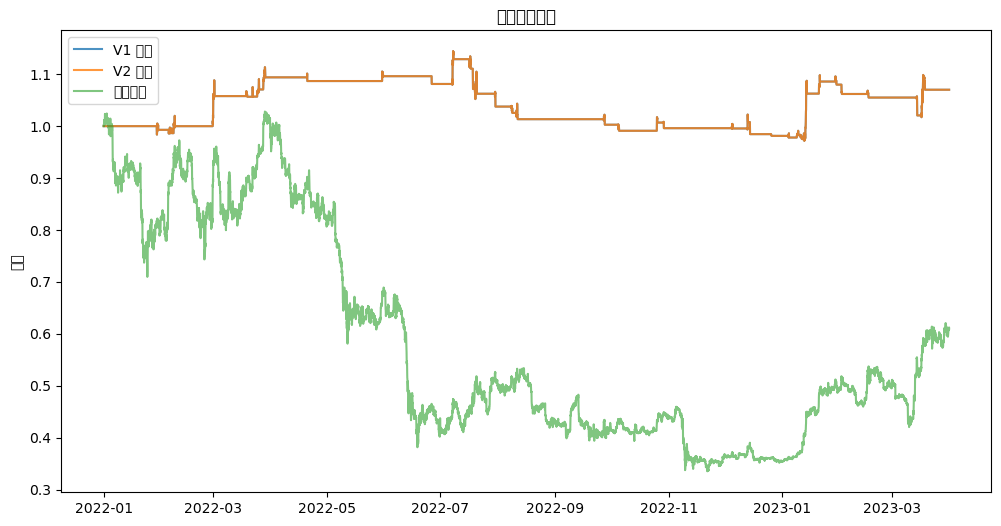

V2 交易次数: 36
                 买入日期      买入价格                      备注                卖出日期  \
0 2022-01-29 13:00:00  38161.69  开仓: z=1.56, ATR=329.25 2022-01-30 09:00:00   
1 2022-02-04 23:00:00  41574.25  开仓: z=2.09, ATR=529.27 2022-02-06 14:00:00   
2 2022-02-07 14:00:00  43411.15  开仓: z=1.29, ATR=368.25 2022-02-08 08:00:00   
3 2022-02-28 16:00:00  41010.09  开仓: z=0.91, ATR=646.77 2022-03-01 16:00:00   
4 2022-03-18 17:00:00  41661.86  开仓: z=0.94, ATR=331.80 2022-03-19 07:00:00   
5 2022-03-22 03:00:00  42236.46  开仓: z=1.69, ATR=351.93 2022-03-22 06:00:00   
6 2022-03-24 14:00:00  43582.11  开仓: z=1.19, ATR=359.86 2022-03-25 16:00:00   
7 2022-03-27 20:00:00  46115.80  开仓: z=0.93, ATR=315.15 2022-03-28 23:00:00   
8 2022-04-20 10:00:00  41821.38  开仓: z=1.41, ATR=240.65 2022-04-20 14:00:00   
9 2022-05-30 20:00:00  31277.18  开仓: z=2.33, ATR=276.75 2022-05-31 09:00:00   

       卖出价格                 备注  
0  37889.48  止损: stop=37964.61  
1  41306.34  止损: stop=41411.15  
2  44004.51  止损: st

In [6]:
import crypto_process
start_month = '2022-01'
end_month = '2023-03'
freq = '1h'

z_original = crypto_process.load_data(start_month, end_month)
z_resampled = crypto_process.resample_data(z_original, freq)

# V2 预处理：增加趋势过滤、突破、ADX 等特征
z2 = preprocess_data_v2(z_resampled,
                        ret_periods=24, vol_window=24, atr_period=14,
                        sma_fast=48, sma_slow=200, adx_period=14,
                        breakout_lookback=48)

# V2 策略：仅做多、全仓、无费率
params_v2 = dict(
    z_long=0.8,              # 入场信号阈值（z-score）
    k_init=2.0,              # 初始 ATR 止损倍数
    k_trail=2.5,             # 追踪 ATR 止损倍数
    time_stop_hours=24*10,   # 时间止损（10天）
    cool_down_hours=24,      # 冷却期（1天）
    use_adx=True,            # 是否启用 ADX 过滤
    adx_min=15.0             # ADX 最小阈值
)

data_price_v2, transaction_v2 = run_strategy_v2(z2, **params_v2)

# 对比 V1 vs V2 净值
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(data_price_v2.index, data_price_v2['nav'], label='V1 策略', alpha=0.8)
plt.plot(data_price_v2.index, data_price_v2['nav_v2'], label='V2 策略', alpha=0.8)
plt.plot(data_price_v2.index, data_price_v2['benchmark'], label='买入持有', alpha=0.6)
plt.legend()
plt.title('策略净值对比')
plt.ylabel('净值')
plt.show()

# 查看 V2 交易记录
print("V2 交易次数:", len(transaction_v2))
print(transaction_v2.head(10))

In [7]:
data_price.nav.plot()


NameError: name 'data_price' is not defined

In [ ]:
transaction


In [ ]:
print(transaction.to_string())

In [ ]:
import trading_analysis
analysis_results = trading_analysis.comprehensive_trading_analysis(transaction, data_price)
trading_analysis.print_trading_analysis(analysis_results)


In [ ]:
def calculate_performance_metrics(data_price: pd.DataFrame, transactions: pd.DataFrame) -> pd.DataFrame:
    """计算绩效指标（小时年化）"""
    N = 24 * 365  # 小时级年化因子
    rf = 0.02  # 年化无风险收益率

    # 年化收益率（按小时净值序列年化）
    rety = data_price.nav.iloc[-1] ** (N / data_price.shape[0]) - 1

    # 夏普比率（小时收益×仓位）
    strategy_returns = (data_price.ret * data_price.position).fillna(0)
    sharpe = (strategy_returns.mean() * N - rf) / (strategy_returns.std() * np.sqrt(N)) if strategy_returns.std() > 0 else np.nan

    # 胜率（仅在有成对买卖记录时有效）
    try:
        VictoryRatio = ((transactions['卖出价格'] - transactions['买入价格']) > 0).mean()
    except Exception:
        VictoryRatio = np.nan

    # 最大回撤
    DD = 1 - data_price.nav / data_price.nav.cummax()
    MDD = DD.max()

    # 月均交易次数（按小时：每月约 24*30 小时）
    trade_count = data_price.flag.abs().sum() / data_price.shape[0] * (24 * 30)

    result = {
        'Sharpe': sharpe,
        'Annual_Return': rety,
        'MDD': MDD,
        'Winning_Rate': VictoryRatio,
        'Trading_Num': round(trade_count, 1)
    }
    return pd.DataFrame(result, index=[0])


In [ ]:
result = calculate_performance_metrics(data_price,transaction)

In [ ]:
result

In [ ]:
flag = z['flag']

In [ ]:
price_ = z[['close','high','low','open']]

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(z.index, z['close'], label='Close')

# 标记开仓和平仓点
ax.scatter(z[z['flag'] == 1].index, z[z['flag'] == 1]['close'], marker='^', color='red', label='Buy', s=100)
ax.scatter(z[z['flag'] == -1].index, z[z['flag'] == -1]['close'], marker='v', color='green', label='Sell', s=100)

ax.legend()
plt.title("trading signal")
plt.grid(True)
plt.show()


In [ ]:
# 1.掌握事件触发回测框架
# 2.理解复利和单利的区别

In [ ]:
# 设置pandas显示选项以显示所有行和列
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 打印完整的transaction DataFrame
print(transaction)